In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import sem
from tqdm import tqdm

from mas import MCTS, BinaryTree, GreedySARSA, GridWorld, MonteCarloSweep, QLearning


sns.set()

In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Assignment 1

The function for which we use MC sampling $f(x)=\sin^2(x)$

In [96]:
def f(x):
    return np.sin(x) ** 2

Using MC sampling by first drawing from a random distribution and using that to estimate $E(f(x))$.

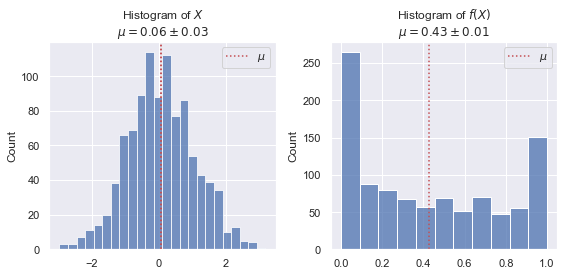

In [97]:
X = np.random.randn(1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(X, ax=ax1)
m = X.mean()
error = sem(X)
ax1.axvline(m, ls=":", c="r", label=f"$\mu$")
ax1.axvline(X.mean(), ls=":", c="r")
ax1.set_title(f"Histogram of $X$\n$\mu={m:.2f} \pm {error:.2f}$")
ax1.legend()

U = f(X)
sns.histplot(U, ax=ax2)
m = U.mean()
error = sem(U)
ax2.axvline(m, ls=":", c="r", label="$\mu$")
ax2.set_title(f"Histogram of $f(X)$\n$\mu={m:.2f} \pm {error:.2f}$")
ax2.legend()

fig.tight_layout()
fig.savefig("1-1.pdf")

The law of large numbers.

C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


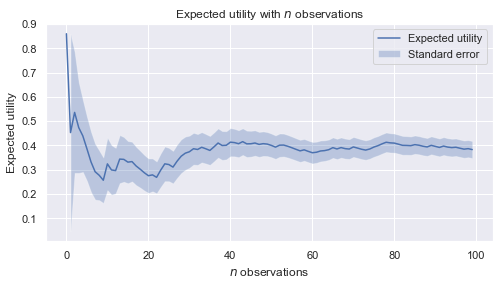

In [98]:
X = np.random.randn(100)
U = f(X)

E = np.array([U[: i + 1].mean() for i in range(len(U))])
error = np.array([sem(U[: i + 1]) for i in range(len(U))])

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(E, label="Expected utility")
ax.fill_between(range(len(E)), E - error, E + error, alpha=0.3, label="Standard error")
ax.legend()
ax.set_title("Expected utility with $n$ observations")
ax.set_xlabel("$n$ observations")
ax.set_ylabel("Expected utility")

fig.savefig("1-2.pdf")

The selection strategy.

C:\Users\Alex Hoorn\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Alex Hoorn\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


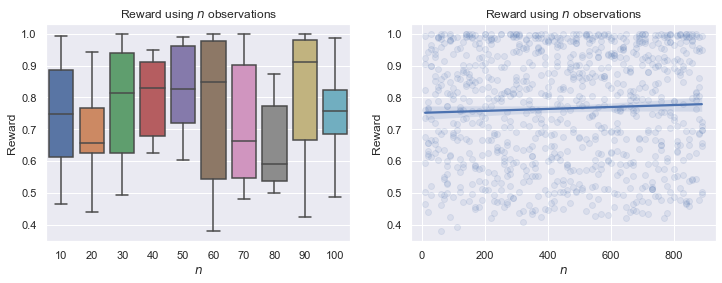

In [100]:
N = np.repeat(np.arange(10, 900, 10), 10)
selects = []

for n in N:
    X = np.random.randn(1000)
    U = f(X)

    U_before = U[:n]
    U_after = U[n:]

    expected = U_before.mean()

    select = U_after[U_after > expected][0]
    selects.append(select)

selects = np.array(selects)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))

submask, = np.where(N<110)
sns.boxplot(N[submask], selects[submask], ax=ax1)
ax1.set_title("Reward using $n$ observations")
ax1.set_xlabel("$n$")
ax1.set_ylabel("Reward")

sns.regplot(N, selects, scatter_kws=dict(alpha=0.1), ax=ax2)
ax2.set_title("Reward using $n$ observations")
ax2.set_xlabel("$n$")
ax2.set_ylabel("Reward")

fig.savefig("1-3.pdf")

---

# Assignment 2

Exploring what B and r should be set to.

C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_23504/3740840755.py:2: RuntimeWarning: invalid value encountered in true_divide
  return b * np.e ** -(d / r)
C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_23504/3740840755.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


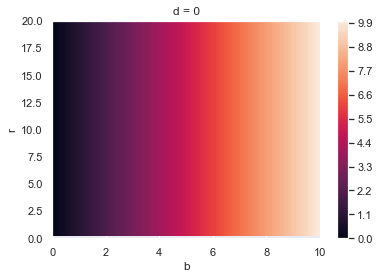

In [46]:
def f(d, b, r):
    return b * np.e ** -(d / r)


b = np.linspace(0, 10, 100)
r = np.linspace(0, 20, 100)

d = 0

plt.contourf(b, r, f(d, *np.meshgrid(b, r)), levels=100)
plt.xlabel("b")
plt.ylabel("r")
plt.title(f"{d = }")
plt.colorbar()

C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_23504/3740840755.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return b * np.e ** -(d / r)
C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_23504/2080541213.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


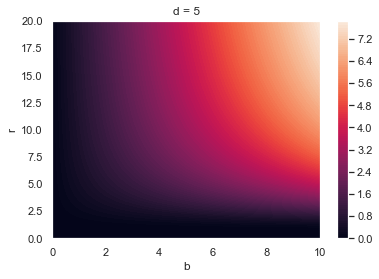

In [47]:
d = 5

plt.contourf(b, r, f(d, *np.meshgrid(b, r)), levels=100)
plt.xlabel("b")
plt.ylabel("r")
plt.title(f"{d = }")
plt.colorbar()

The binary tree class. This is an extremely simple implementation which just generates a random target path and calculates rewards lazily. Can pretty much be of infinite size because of this.

In [48]:
tree = BinaryTree(depth=10000)

path = list(tree.target)
path[0:10] = np.random.choice(tree.choices, 10)
path = tuple(path)
substring = "".join(path[:5]) + "..." + "".join(path[-5:])

print(f"Semi random path {substring} with reward {tree.get_reward(path)}")

Semi random path RRLRR...RRLLR with reward 1.6374615061559636


The Monte Carlo Tree Search algorithm.

In [49]:
tree = BinaryTree(depth=50)

target = tree.target
"".join(target), tree.get_reward(target)

('LLRRLLLLRRRRLRRLRRLRLRRRRRRLRLLLLLRLLRRRRLRRLLRLLL', 2.0)

I have implemented early stopping. If in an iteration the path selected through UCB reaches a leaf node then the patience counter is upped by one. If the counter reaches its max then a new root is selecter earlier than exhausting the full amount of iterations. This isn't necessarily consistently better. But it is faster and I simply wanted to add a little flavor of my own. 

In [50]:
mcts = MCTS(tree, c=100, iterations=50, max_patience=5, rollouts=50)
mcts.run()

mcts.print_solution()

Found reward=2.00 with path=`LLRRLLLLRRRRLRRLRRLRLRRRRRRLRLLLLLRLLRRRRLRRLLRLLL` in 0.74s and 591 steps


Measuring the impact of c-parameter.

In [61]:
tree = BinaryTree(depth=25)

runtimes = []
steps = []
stops = []
cs = []
rewards = []

for c in np.arange(0, 100, 0.5):
    mcts = MCTS(tree, c=c)
    mcts.run()

    runtimes.append(mcts.runtime)
    steps.append(mcts.search_iterations)
    stops.append(mcts.early_stops)
    cs.append(c)
    rewards.append(mcts.reward)

Showing the impact of the c-parameter.

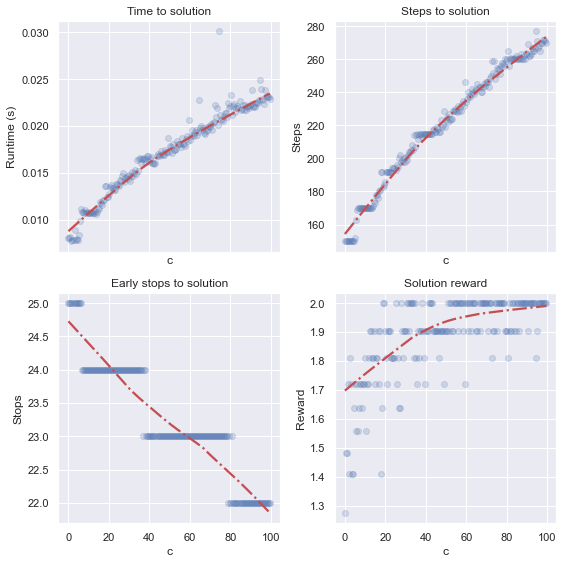

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
reg_kwargs = dict(
    lowess=True, scatter_kws=dict(alpha=0.2), line_kws=dict(color="r", linestyle="-.")
)

sns.regplot(x=cs, y=runtimes, ax=ax1, **reg_kwargs)
ax1.set_ylabel("Runtime (s)")
ax1.set_xlabel("c")
ax1.set_title("Time to solution")

sns.regplot(x=cs, y=steps, ax=ax2, **reg_kwargs)
ax2.set_ylabel("Steps")
ax2.set_xlabel("c")
ax2.set_title("Steps to solution")

sns.regplot(x=cs, y=stops, ax=ax3, **reg_kwargs)
ax3.set_ylabel("Stops")
ax3.set_xlabel("c")
ax3.set_title("Early stops to solution")

sns.regplot(x=cs, y=rewards, ax=ax4, **reg_kwargs)
ax4.set_ylabel("Reward")
ax4.set_xlabel("c")
ax4.set_title("Solution reward")

fig.tight_layout()
fig.savefig("2-1.pdf")

---

# Assignment 3

The gridworld.

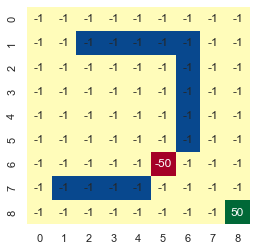

In [107]:
terminals = {(6, 5): -50, (8, 8): 50}
walls = (
    [(1, i) for i in range(2, 7)]
    + [(i, 6) for i in range(2, 6)]
    + [(7, i) for i in range(1, 5)]
)

gw = GridWorld(terminals=terminals, walls=walls, gridsize=(9, 9))
ax = gw.plot_grid()
ax.get_figure().savefig("gridworld.pdf")

Monte Carlo Sweep.

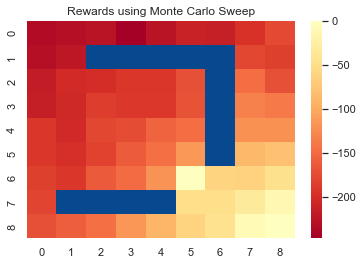

In [65]:
mcs = MonteCarloSweep(gw)
mcs.evaluate(500)

ax = mcs.plot_rewards()
ax.get_figure().savefig("3-1.pdf")

SARSA and Q-Learning

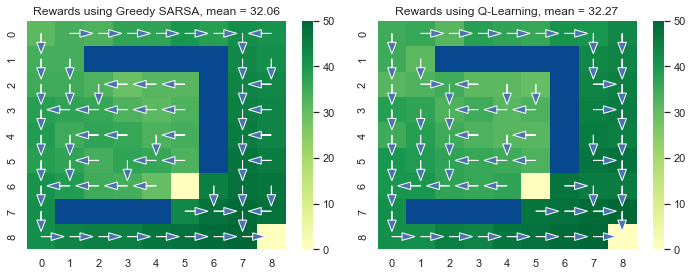

In [89]:
gsarsa = GreedySARSA(gw)
gsarsa.evaluate(1000)

qlearn = QLearning(gw)
qlearn.evaluate(1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

gsarsa.plot_rewards(ax=ax1)
qlearn.plot_rewards(ax=ax2)

fig.tight_layout()
fig.savefig("3-2.pdf")

Comparing performance.

In [102]:
N = []
gsarsa_runtimes = []
gsarsa_means = []
qlearn_runtimes = []
qlearn_means = []

for n in tqdm(range(0, 505, 5)):
    N.append(n)

    gsarsa = GreedySARSA(gw)
    gsarsa.evaluate(n)
    gsarsa_runtimes.append(gsarsa.runtime)
    gsarsa_means.append(np.mean(gsarsa.rewards))

    qlearn = QLearning(gw)
    qlearn.evaluate(n)
    qlearn_runtimes.append(qlearn.runtime)
    qlearn_means.append(np.mean(qlearn.rewards))

100%|██████████| 101/101 [00:28<00:00,  3.59it/s]


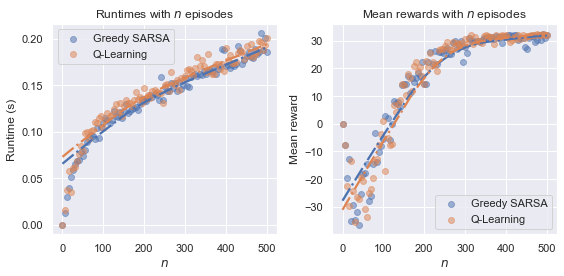

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
reg_kwargs = dict(
    lowess=True, scatter_kws=dict(alpha=0.5), line_kws=dict(linestyle="-.")
)

sns.regplot(x=N, y=gsarsa_runtimes, ax=ax1, label="Greedy SARSA", **reg_kwargs)
sns.regplot(x=N, y=qlearn_runtimes, ax=ax1, label="Q-Learning", **reg_kwargs)
ax1.set_title("Runtimes with $n$ episodes")
ax1.set_ylabel("Runtime (s)")
ax1.set_xlabel("$n$")
ax1.legend()

sns.regplot(x=N, y=gsarsa_means, ax=ax2, label="Greedy SARSA", **reg_kwargs)
sns.regplot(x=N, y=qlearn_means, ax=ax2, label="Q-Learning", **reg_kwargs)
ax2.set_title("Mean rewards with $n$ episodes")
ax2.set_ylabel("Mean reward")
ax2.set_xlabel("$n$")
ax2.legend()

fig.tight_layout()
fig.savefig("3-3.pdf")